In [33]:
from pathlib import Path
import time

from tqdm import tqdm
import pandas as pd
import scanpy as sc
import partipy as pt
import plotnine as pn
import matplotlib.pyplot as plt

from data_utils import load_ms_data
from const import FIGURE_PATH, OUTPUT_PATH

## set up backend for matplotlib: https://matplotlib.org/stable/users/explain/figure/backends.html
#matplotlib.use("Agg")

## set up output directory
figure_dir = Path(FIGURE_PATH) / "ms_bench"
figure_dir.mkdir(exist_ok=True, parents=True)

output_dir = Path(OUTPUT_PATH) / "ms_bench"
output_dir.mkdir(exist_ok=True, parents=True)

## setting up the optimization seetings
init_alg_list = pt.const.INIT_ALGS
optim_alg_list = [alg for alg in pt.const.OPTIM_ALGS if alg != "regularized_nnls"]
optim_settings_list = []
for init_alg in init_alg_list:
    for optim_alg in optim_alg_list:
        optim_settings_list.append(
            {
                "init_alg": init_alg,
                "optim_alg": optim_alg,
            }
        )
print(f"{len(optim_settings_list)=}")

## setting up different seeds to test
seed_list = [383329927, 3324115916, 2811363264, 1884968544, 1859786275, 
             3687649985, 369133708, 2995172877, 865305066, 404488628,
             2261209995, 4190266092, 3160032368, 3269070126, 3081541439, 
             3376120482, 2204291346, 550243861, 3606691181, 1934392872]

## downloading the data (or using cached data)
atlas_adata = load_ms_data()
print(atlas_adata)

## cell types to consider
celltype_column = "celltype"
celltype_labels = ["MG", "AS", "OL"]
print(atlas_adata.obs.value_counts(celltype_column))

## number of archetypes per celltype
archetypes_to_test = list(range(2, 15))
number_of_archetypes_dict = {
    "MG": 7,
    "AS": 11,
    "OL": 5
}
assert set(celltype_labels) == set(number_of_archetypes_dict.keys())
number_of_pcs_dict = {
    "MG": 10,
    "AS": 10,
    "OL": 10
}
assert set(celltype_labels) == set(number_of_pcs_dict.keys())

## initialize list to save the benchmarking results
result_list = []

for celltype in celltype_labels:

    ## set up plotting directory per celltype
    figure_dir_celltype = figure_dir / celltype
    figure_dir_celltype.mkdir(exist_ok=True)

    ## subsetting and preprocessing per celltype
    adata = atlas_adata[atlas_adata.obs[celltype_column]==celltype, :].copy()
    print("\n#####\n->", celltype, "\n", adata)
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)
    sc.pp.pca(adata, mask_var="highly_variable")

    sc.pl.highly_variable_genes(adata, log=False, show=False, save=False)
    plt.savefig(figure_dir_celltype / "highly_variable_genes.png")

    sc.pl.pca_variance_ratio(adata, n_pcs=50, log=False, show=False, save=False)
    plt.savefig(figure_dir_celltype / "pca_variance_explained.png")

    sc.pl.pca(adata, color=["lesion_type", "subtype"], dimensions=[(0, 1), (0, 1)],
              ncols=2, size=10, alpha=0.75, show=False, save=False)
    plt.savefig(figure_dir_celltype / "pca_2D.png")

    ## for simplicity we will always use 10 principal components
    pt.set_dimension_aa(adata=adata, n_pcs=number_of_pcs_dict[celltype])

    ## check for the number of archetypes
    pt.var_explained_aa(adata=adata, min_a=archetypes_to_test[0], max_a=archetypes_to_test[-1], n_jobs=20)

    p = pt.plot_var_explained(adata)
    p.save(figure_dir_celltype / f"plot_var_explained.png", dpi=300)

    p = pt.plot_IC(adata)
    p.save(figure_dir_celltype / f"plot_IC.png", dpi=300)

    break

len(optim_settings_list)=6
File already exists, skipping: data/sn_atlas.h5ad
File already exists, skipping: data/GSE279183_RAW.tar
Extraction directory already exists, skipping: data/GSE279183_extracted
AnnData object with n_obs × n_vars = 103794 × 32115
    obs: 'patient_id', 'sample_id', 'condition', 'lesion_type', 'age', 'sex', 'rin', 'pmi_hrs', 'duration_y', 'ms_class', 'cause_death', 'batch_sn', 'celltype', 'subtype'
    var: 'index', 'highly_variable', 'highly_variable_nbatches', 'gene_name', 'gene_type'
    obsm: 'X_pca', 'X_umap'
celltype
OL     64834
AS     13987
MG      9239
NEU     8171
OPC     3945
EC      2230
TC       835
SC       277
BC       276
Name: count, dtype: int64

#####
-> MG 
 AnnData object with n_obs × n_vars = 9239 × 32115
    obs: 'patient_id', 'sample_id', 'condition', 'lesion_type', 'age', 'sex', 'rin', 'pmi_hrs', 'duration_y', 'ms_class', 'cause_death', 'batch_sn', 'celltype', 'subtype'
    var: 'index', 'highly_variable', 'highly_variable_nbatches', 'ge

/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 3 in image.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/ms_bench/MG/plot_var_explained.png
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 3 in image.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: figures/ms_bench/MG/plot_IC.png


In [25]:
adata.obs

,patient_id,sample_id,condition,lesion_type,age,sex,rin,pmi_hrs,duration_y,ms_class,cause_death,batch_sn,celltype,subtype
cell_id,,,,,,,,,,,,,,
CO37-GATCACATCTCGAGTA,CO37 P5B3,CO37,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,4.0,MG,MG_Homeo2
CO37-CTGGCAGCAGACAATA,CO37 P5B3,CO37,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,4.0,MG,MG_NA
CO37-ACTGCAAGTCTGTCAA,CO37 P5B3,CO37,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,4.0,MG,MG_Homeo2
CO37-ACGTTCCGTCTACTGA,CO37 P5B3,CO37,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,4.0,MG,MG_Phago1
CO37-AACACACTCGATGCTA,CO37 P5B3,CO37,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,4.0,MG,MG_Homeo2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MS549T-GGAGAACGTCGATGCC,MS549 P2D5,MS549T,MS,CI,50,M,8.0,8.0,29.0,SPMS,MS,3.0,MG,MG_Homeo3
MS549T-GAATAGATCTTTCGAT,MS549 P2D5,MS549T,MS,CI,50,M,8.0,8.0,29.0,SPMS,MS,3.0,MG,MG_Dis
MS549T-TCCGAAAGTATGTCTG,MS549 P2D5,MS549T,MS,CI,50,M,8.0,8.0,29.0,SPMS,MS,3.0,MG,MG_Homeo2


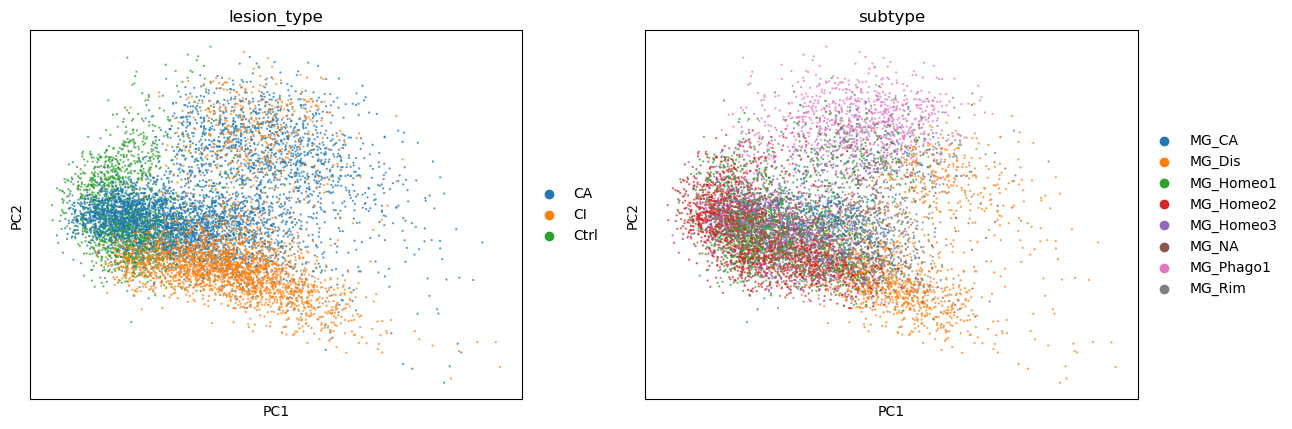

In [32]:
sc.pl.pca(
    adata,
    color=["lesion_type", "subtype"],
    dimensions=[(0, 1), (0, 1)],
    ncols=2, size=10, alpha=0.75
)

In [34]:
print(atlas_adata.obs.value_counts(celltype_column))

celltype
OL     64834
AS     13987
MG      9239
NEU     8171
OPC     3945
EC      2230
TC       835
SC       277
BC       276
Name: count, dtype: int64
